In [37]:
import numpy as np
print(np.__version__)
import math

import torch
print(torch.__version__)

print(torch.cuda.is_available())

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

import matplotlib.pyplot as plt

from tqdm import trange

import random

1.26.4
2.3.0+cu121
True


In [38]:
class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player

        return state

    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False

        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]

        return (
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True # 0 means draw
        return 0, False # False means not terminated
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

In [39]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()
        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )

        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )

        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

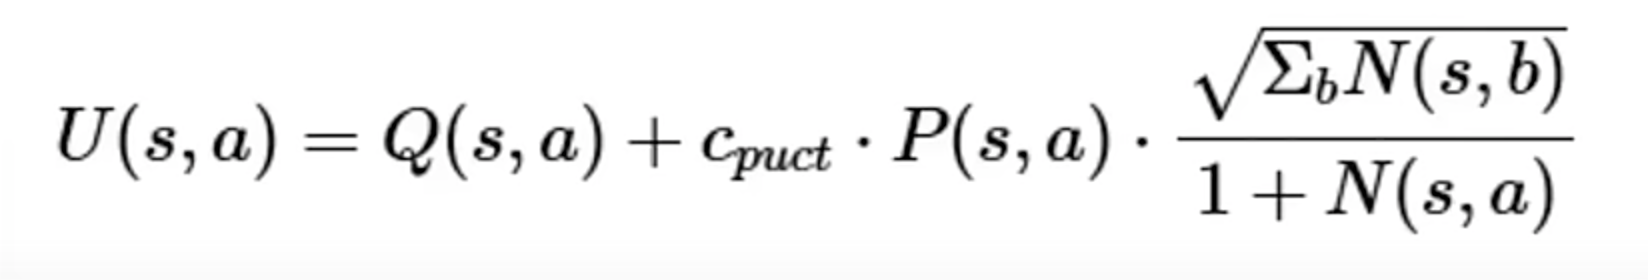

In [40]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []

        self.visit_count = 0
        self.value_sum = 0

    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb= self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
        
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1)/2 
        # Think about: Since value_sum could be negative, we do this to make q_value be a probability
        # We do "1 - " because we want to put opponent in a bad situation
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)

        return child

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        value = self.game.get_opponent(value)
        if self.parent is not None:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad() # We don't use this for training
    def search(self, state):
        # define root
        root = Node(self.game, self.args, state)

        for search in range(self.args['num_searches']):
            node = root

            # selection
            while node.is_fully_expanded():
                node = node.select()

            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)

                value = value.item()

                node = node.expand(policy)

            node.backpropagate(value)

        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
            
            # expansion
            # simulation
            # backpropagation

        # return visit_counts

In [41]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)

    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()

        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)

            memory.append((neutral_state, action_probs, player))

            action = np.random.choice(self.game.action_size, p=action_probs)

            state = self.game.get_next_state(state, action, player)

            value, is_terminal = self.game.get_value_and_terminated(state, action)

            if is_terminal:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            player = self.game.get_opponent(player)

    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:batchIdx + self.args['batch_size']]
            state, policy_targets, value_targets = zip(*sample)

            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

            state = torch.tensor(state, dtype=torch.float32)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32)
            value_targets = torch.tensor(value_targets, dtype=torch.float32)

            out_policy, out_value = self.model(state)

            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def learn(self):
        for iteration in trange(self.args['num_iterations']):
            memory = []

            self.model.eval()
            # print("model eval")
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()

            # print("model train")
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model_{iteration}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [43]:
tictactoe = TicTacToe()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(tictactoe, 4, 64, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
args = {
    'C': 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_epochs': 4,
    'batch_size': 64
}

alphaZero = AlphaZero(model, optimizer, tictactoe, args)
alphaZero.learn()

  0%|          | 0/3 [00:45<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
tictactoe = TicTacToe()
player = 1

args = {
    'C': 2,
    'num_searches': 1000
}

model = ResNet(tictactoe, 4, 64)
model.load_state_dict(checkpoint['state'])
model.eval()

mcts = MCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()

while True:
    print(state)

    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        list_valid_moves = [i for i in range(tictactoe.action_size) if valid_moves[i] == 1]
        print("valid moves: ", list_valid_moves)

        action = int(input(f"Player {player}, please move: "))
        if action not in list_valid_moves:
            print("Action is not valid.")
            continue
    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
        
    state = tictactoe.get_next_state(state, action, player)

    value, is_terminal = tictactoe.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(player, " won")
        else:
            print("Draw")
        break

    player = tictactoe.get_opponent(player)

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "startBlock.0.weight", "startBlock.0.bias", "startBlock.1.weight", "startBlock.1.bias", "startBlock.1.running_mean", "startBlock.1.running_var", "backBone.0.conv1.weight", "backBone.0.conv1.bias", "backBone.0.bn1.weight", "backBone.0.bn1.bias", "backBone.0.bn1.running_mean", "backBone.0.bn1.running_var", "backBone.0.conv2.weight", "backBone.0.conv2.bias", "backBone.0.bn2.weight", "backBone.0.bn2.bias", "backBone.0.bn2.running_mean", "backBone.0.bn2.running_var", "backBone.1.conv1.weight", "backBone.1.conv1.bias", "backBone.1.bn1.weight", "backBone.1.bn1.bias", "backBone.1.bn1.running_mean", "backBone.1.bn1.running_var", "backBone.1.conv2.weight", "backBone.1.conv2.bias", "backBone.1.bn2.weight", "backBone.1.bn2.bias", "backBone.1.bn2.running_mean", "backBone.1.bn2.running_var", "backBone.2.conv1.weight", "backBone.2.conv1.bias", "backBone.2.bn1.weight", "backBone.2.bn1.bias", "backBone.2.bn1.running_mean", "backBone.2.bn1.running_var", "backBone.2.conv2.weight", "backBone.2.conv2.bias", "backBone.2.bn2.weight", "backBone.2.bn2.bias", "backBone.2.bn2.running_mean", "backBone.2.bn2.running_var", "backBone.3.conv1.weight", "backBone.3.conv1.bias", "backBone.3.bn1.weight", "backBone.3.bn1.bias", "backBone.3.bn1.running_mean", "backBone.3.bn1.running_var", "backBone.3.conv2.weight", "backBone.3.conv2.bias", "backBone.3.bn2.weight", "backBone.3.bn2.bias", "backBone.3.bn2.running_mean", "backBone.3.bn2.running_var", "policyHead.0.weight", "policyHead.0.bias", "policyHead.1.weight", "policyHead.1.bias", "policyHead.1.running_mean", "policyHead.1.running_var", "policyHead.4.weight", "policyHead.4.bias", "valueHead.0.weight", "valueHead.0.bias", "valueHead.1.weight", "valueHead.1.bias", "valueHead.1.running_mean", "valueHead.1.running_var", "valueHead.4.weight", "valueHead.4.bias". 
	Unexpected key(s) in state_dict: "state", "param_groups". 